# Tutorial on Variational Quantum Eigensolver (Part III vs Part II)
# *Hadamard test* vs direct Measurement of all qubits

---
This code was mostly based on Qiskit Variational Quantum Eigensolver Playground, you can find in [Github](https://github.com/JavaFXpert/vqe-playground). Please run all the cells in order.

We saw in Part III that the convergence of the VQE algorithm is slower or even sometimes it does not converge.

In this Notebook we are going to analize the energy estimation of both circuits to see what is the difference of Hadamard test estimation versus the Measurement of all quibits we saw in Part II

Maybe this will point us to the reason of different convergence times

## Import libraries  

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.

In [28]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from matplotlib import pyplot as plt

print("Libraries loaded successfully.")

Libraries loaded successfully.


## Definition of the Circuit
We already went through the details of classes `CircuitGridNode` and `CircuitGridModel` in PART I 

In [3]:
class CircuitGridNode():
    def __init__(self, node_type, radians=0.0, ctrl_a=-1):
        self.node_type = node_type
        self.radians = radians
        self.ctrl_a = ctrl_a
        self.wire_num = -1
        self.column_num = -1

Two separate Circuits: **`CircuitGridModel`** and  **`CircuitGridModelHadTest`**

In [4]:
class CircuitGridModelHadTest():

    def __init__(self):
        # Define the Quantum Circuit to generate the Ansatz + Other Measurement Circuit
        self.max_wires = NUM_QUBITS
        self.max_columns = 21           # Columns for the circuit. 21 Columns for the Entanglement/Tuning Circuit
                                        # 1 extra wire as ancilla , 4 extra columns for Hadamard and Control Z.
        self.nodes = np.empty((self.max_wires+1, self.max_columns+4),
                                dtype = CircuitGridNode)
        
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                if column_num % 5 == 0:
                    self.nodes[wire_num][column_num] = CircuitGridNode(Ygate, np.pi)              # Ry(pi)
                    self.nodes[wire_num][column_num].wire_num = wire_num
                    self.nodes[wire_num][column_num].column_num = column_num
                else: 
                    if wire_num != 0 and wire_num == column_num % 5:
                        self.nodes[wire_num][column_num] = CircuitGridNode(Xgate, 0, wire_num-1)  # CNOT 
                        self.nodes[wire_num][column_num].wire_num = wire_num
                        self.nodes[wire_num][column_num].column_num = column_num
        
        # Measurement part of the Circuit : Add the Controlled to the Ancilla and Hadamard.
        self.nodes[5][21] = CircuitGridNode(Hgate)                       
        self.nodes[5][22] = CircuitGridNode(Zgate, 5, 4)  # CZ4    we initialize with Z3 Z4 as example 
        self.nodes[5][23] = CircuitGridNode(Zgate, 5, 3)  # CZ3    
        self.nodes[5][24] = CircuitGridNode(Hgate)
        self.nodes[5][21].wire_num = 5  ;  self.nodes[5][21].column_num = 21
        self.nodes[5][22].wire_num = 5  ;  self.nodes[5][22].column_num = 22
        self.nodes[5][23].wire_num = 5  ;  self.nodes[5][23].column_num = 23
        self.nodes[5][24].wire_num = 5  ;  self.nodes[5][24].column_num = 24
    
    def Control_Hi(self, index):
        # Make the Hadamard Test Circuit different for each and every H sum Term
        # H1 = (3/2)Z0Z1   ;   H2 = (1/2)Z0Z2   ;   H3 = (3/2)Z0Z3
        # H4 = (3/2)Z2Z3   ;   H5 = (2/2)Z1Z4   ;   H6 = (2/2)Z3Z4 
        if index == 0:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 0)  # CZ0
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 1)  # CZ1   
        elif index == 1:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 0)  # CZ0
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 2)  # CZ2   
        elif index == 2:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 0)  # CZ0
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 3)  # CZ3   
        elif index == 3:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 2)  # CZ2
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 3)  # CZ3   
        elif index == 4:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 1)  # CZ1
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 4)  # CZ4   
        elif index == 5:
            self.nodes[5][22] = CircuitGridNode(Zgate, 5, 3)  # CZ3
            self.nodes[5][23] = CircuitGridNode(Zgate, 5, 4)  # CZ4   
            
    def get_rotation_gate_nodes(self):
        rot_gate_nodes = []
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node and node.node_type == Ygate:
                    rot_gate_nodes.append(node)
        return rot_gate_nodes
    
    def compute_circuit(self):
        qr = QuantumRegister(NUM_QUBITS, 'q')
        anc = QuantumRegister(1, 'ancilla')
        cr = ClassicalRegister(1, 'c')
        qc = QuantumCircuit(qr, anc, cr)
    
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns+4):
            qc.barrier(qr) ; qc.barrier (anc)
            for wire_num in range(self.max_wires+1):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)       # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
                    elif node.node_type == Zgate:  qc.cz(node.ctrl_a, wire_num)       # Controlled Z gate
                    elif node.node_type == Hgate:  qc.h(wire_num)                     # Hadamard Gate
        
        # Add Measurement at the end
        qc.measure(anc, cr)       
        return qc
    
    def compute_circuit_ansatz(self):
        # Function aimed to measure the final Ansatz
        qr = QuantumRegister(NUM_QUBITS, 'q')
        cr = ClassicalRegister(NUM_QUBITS, 'c')
        qc = QuantumCircuit(qr, cr)
    
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns+4):
            for wire_num in range(self.max_wires+1):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)       # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
        # Add Measurement at the end
        qc.measure(qr, cr)       
        return qc

In [5]:
class CircuitGridModel():

    def __init__(self):
        # Define the Quantum Circuit to generate the Ansatz + Other Measurement Circuit
        self.max_wires = NUM_QUBITS
        self.max_columns = 21            # Columns for the circuit. 21 Columns for the Entanglement/Tuning Circuit
        self.nodes = np.empty((self.max_wires, self.max_columns),
                                dtype = CircuitGridNode)
        
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                if column_num % 5 == 0:
                    self.nodes[wire_num][column_num] = CircuitGridNode(Ygate, np.pi)              # Ry(pi)
                    self.nodes[wire_num][column_num].wire_num = wire_num
                    self.nodes[wire_num][column_num].column_num = column_num
                else: 
                    if wire_num != 0 and wire_num == column_num % 5:
                        self.nodes[wire_num][column_num] = CircuitGridNode(Xgate, 0, wire_num-1)  # CNOT 
                        self.nodes[wire_num][column_num].wire_num = wire_num
                        self.nodes[wire_num][column_num].column_num = column_num
        
        # Measurement part of the Circuit 
        # Not applicable in Brute Force

    def get_rotation_gate_nodes(self):
        rot_gate_nodes = []
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node and node.node_type == Ygate:
                    rot_gate_nodes.append(node)
        return rot_gate_nodes
    
    def compute_circuit(self):
        qr = QuantumRegister(NUM_QUBITS, 'q')
        cr = ClassicalRegister(NUM_QUBITS, 'c')
        qc = QuantumCircuit(qr, cr)
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns):
            qc.barrier(qr)
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)   # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
        
        # Add Measurement at the end
        qc.barrier(qr)
        qc.measure(qr, cr) 
        return qc

## Global Functions:

`ExperimentAndMeasure` Sets up the Qiskit Simulator, Executes the simulation `n_experiments` times and return the results as an histogram (dictionary of results in the format: {'000': n1, '001': n2 ....}). In this case we will be measuring only the ancilla qubit.

Also we define an array with all de weights of the $H_i$ and a temporary array `Energies_Hi` that will help us store the partial expectation values as we go calculating each one of the 6 terms of the sum.

In [6]:
# H1 = (3/2)Z0Z1   ;   H2 = (1/2)Z0Z2   ;   H3 = (3/2)Z0Z3
# H4 = (3/2)Z2Z3   ;   H5 = (2/2)Z1Z4   ;   H6 = (2/2)Z3Z4 
Sum_Term_Weights = [3/2,1/2,3/2,3/2,1,1]          # This array will hold the weight of every H_i term.
Energies_Hi = [0,0,0,0,0,0]                # This will hold the expectation Values of the terms H_i.

I=[[1,0], [0,1]]
Z=[[1,0], [0,-1]]
II=np.kron(I,I)
ZZ=np.kron(Z,Z)
ZI=np.kron(Z,I)
IZ=np.kron(I,Z)
# Note IIIZZ is the Diagonal of the actual Matrix
IIIZZ=np.diag(np.kron(I,np.kron(II,ZZ)))
IIZIZ=np.diag(np.kron(I,np.kron(IZ,IZ)))
IZIIZ=np.diag(np.kron(I,np.kron(ZI,IZ)))
IZZII=np.diag(np.kron(I,np.kron(ZZ,II)))
ZIIZI=np.diag(np.kron(Z,np.kron(II,ZI)))
ZZIII=np.diag(np.kron(ZZ,np.kron(II,I)))
    
# Extract the Eigenvalues in the Diagonal for each Term and multiply by corresponding factor 
Eigen_1=[(3/2)*float(i) for i in IIIZZ]
Eigen_2=[(1/2)*float(i) for i in IIZIZ]
Eigen_3=[(3/2)*float(i) for i in IZIIZ]
Eigen_4=[(3/2)*float(i) for i in IZZII]
Eigen_5=[(2/2)*float(i) for i in ZIIZI]
Eigen_6=[(2/2)*float(i) for i in ZZIII]   
Eigen_SUM=[Eigen_1[i]+Eigen_2[i]+Eigen_3[i]+Eigen_4[i]+Eigen_5[i]+Eigen_6[i] for i in range(32)]


def ExperimentAndMeasure(circuit):
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circuit, backend_sim, shots=n_experiments)
    result_sim = job_sim.result()
    prob_distro = result_sim.get_counts(circuit)
    return prob_distro

def dict_to_array(prob_distro):
    Prob_i=[]
    for name in basis_states:
        prob_distro.setdefault(name, 0)
        Prob_i.append(float(prob_distro.get(name))/n_experiments)
    return Prob_i
    
def calc_expectation_value(prob_distro):
    Prob_i = dict_to_array(prob_distro)
    new_energy = np.dot(Eigen_SUM,Prob_i)
    return new_energy, prob_distro, np.argmax(Prob_i)

## Global Function to Recalculate Circuit and Recalculate Expectation Value 
`calc_new_energyHadTest` and  `calc_new_energy` to calculate Energy for both Circuits

In [7]:
def calc_new_energyHadTest(circuit_grid_model, rotation_gate_nodes):
    
    for idx in range(len(rotation_gate_nodes)):
        rotation_gate_nodes[idx].radians = optimized_rotations[idx]
        
    for i in range(6):
        circuit_grid_model.Control_Hi(i)
        circuit = circuit_grid_model.compute_circuit()
        prob_distro = ExperimentAndMeasure(circuit)
        Energies_Hi[i] = (prob_distro.setdefault('0', 0) - prob_distro.setdefault('1', 0))
        Energies_Hi[i] = Energies_Hi[i] * Sum_Term_Weights[i] / n_experiments 
   
    estimated_Energy = sum(Energies_Hi)
    return estimated_Energy

def calc_new_energy(circuit_grid_model, rotation_gate_nodes):

    for idx in range(len(rotation_gate_nodes)):
        rotation_gate_nodes[idx].radians = optimized_rotations[idx]
    
    quantumcircuit = circuit_grid_model.compute_circuit()
    prob_distro = ExperimentAndMeasure(quantumcircuit)
    
    return calc_expectation_value(prob_distro)

## Global Function to Optimize Rotations
This function will contain the **classical optimization algorithm** to finetune the angles and make sure that the Energy of the resulting state will be minimal.

As input it will gate the, the Class with the Circuit, the Class with the Expectation grid and the array of nodes with Ry Gates. As output it will proyect the latest optimized energy the variable `energy` and the latest *optimal* basis state (basis state with highest probability) 

`cur_rotation_num` will be the node containing the Ry Gate currently being updated and optimized. Will be a counter 25 times. For each gate, the algorithm will start rotating a fixed angle on one direction, if the Energy stays or decreasis it will continue rotating, if it increases, then it will change direction of rotation unless it already changed direction before. In that case or if the angle is out of the $ [0,2\pi] $ range, it will move to the next gate.  

In [8]:
def optimize_rotations(circuit_grid_model, rotation_gate_nodes):
    global energy, move_radians, cur_rotation_num, rot_direction, prob_distro, maxindex, Fin_optimizacion

    if cur_rotation_num < len(optimized_rotations):   # Are we on the last Ry Gate?
        cur_ang_rad = optimized_rotations[cur_rotation_num]
        proposed_cur_ang_rad = cur_ang_rad
        proposed_cur_ang_rad += move_radians * rot_direction
        
        if (0.0 <= proposed_cur_ang_rad <= np.pi * 2 + 0.01) and (num_times_rot_dir_change[cur_rotation_num]<2):
            optimized_rotations[cur_rotation_num] = proposed_cur_ang_rad               
            
            # Calculate new Energy with the new Circuit, Quantum Qiskit circuit is called here.
            temp_energy, prob_distro, maxindex = calc_new_energy(circuit_grid_model, rotation_gate_nodes)
            if temp_energy > energy: 
                # NOT OPTIMIZED. Distance is increasing so restore the angle and change direction of rot
                optimized_rotations[cur_rotation_num] = cur_ang_rad
                rot_direction *= -1
                num_times_rot_dir_change[cur_rotation_num] += 1
            else:
                # OPTIMIZED or equal. Distance decreasing, so keep the proposed angle and update Energy
                energy = temp_energy
        else:                                       
            cur_rotation_num += 1       # Out of [0,2pi] range or changed direction twice. Move to next Gate.
    else:
        Fin_optimizacion = True         # We reached the last Ry, optimization process is over    
    
    return energy, prob_distro, maxindex

## Definitions and Initializations
In this segment of code we will initialize global variables that will be used in the Main and optimization algorithm. One of the important variables is the Rotation step. Note the Adjacency Matrix does not show up as it is embedded in the Hamiltonian we have manually calculated.

In [15]:
NUM_QUBITS = 5                                                 # Qubits to model the problem
Xgate = 1 ; Ygate = 2 ; Zgate = 3 ; Hgate = 4                  # Gate Definitions    
basis_states = []                                              # List of Basis states in Text format
for idx in range(2**NUM_QUBITS):
    state = format(idx, '0' + str(NUM_QUBITS) + 'b')
    basis_states.append(state)
    

n_experiments = 1024
proposed_cur_ang_rad = 0
cur_ang_rad = 0
rot_direction = 1
iteration=0
Fin_optimizacion = False  
cur_rotation_num = 0
maxindex = None
move_radians = np.pi / 8                             # Rotation Step
                                                     # Consider Randomization of this parameter

## Initialization of the Circuit and Visual Output
Here we will initialize the circuit for first time and will calculate the Ansatz State of the all the Ry gates with $\pi$ radians. Also it will create the expectation grid for the first time.

When the expectation grid is initialized, it will convert the Adjacency matrix to the Ising Hamiltonian and will print its output in gate format (I and Z gates)

On this piece of code we also print the Quantum Optimization Circuit using the Qiskit drawing capabilities as well as the Latex output extensions included in the Qiskit programming language to show the Adjacency Matrix in a readable manner.


Complete Quantum Circuit from Part II:


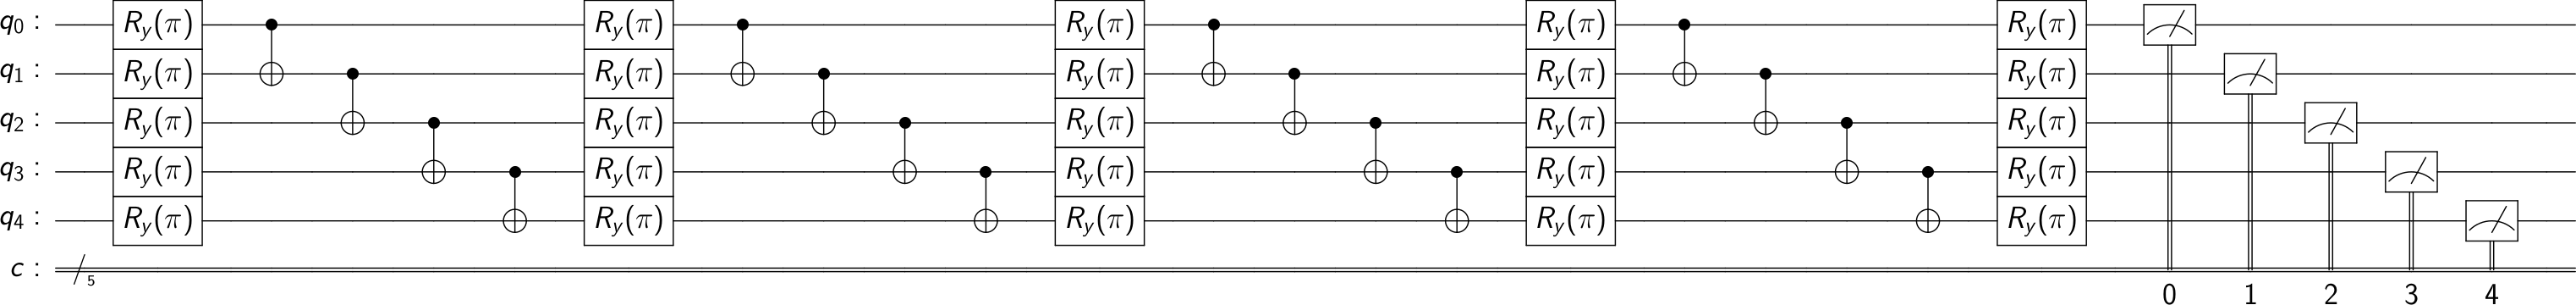

In [10]:
circuit_grid_model = CircuitGridModel()
circuit = circuit_grid_model.compute_circuit()

print("\nComplete Quantum Circuit from Part II:")
display(circuit.draw(output='latex',scale=0.7,justify='left',plot_barriers=False))


Complete Quantum Circuit with Hamiltonian term Z3 Z4 (as example):


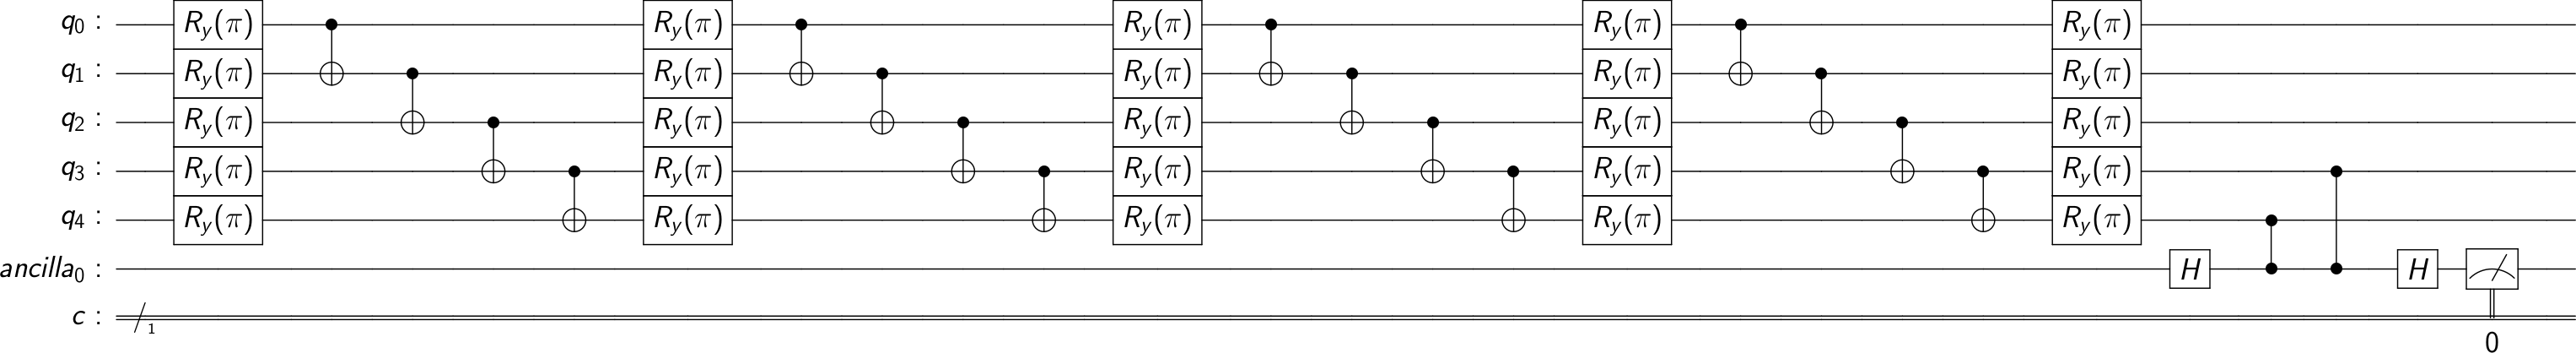

In [11]:
circuit_grid_modelHadTest = CircuitGridModelHadTest()
circuitHadTest = circuit_grid_modelHadTest.compute_circuit()

print("\nComplete Quantum Circuit with Hamiltonian term Z3 Z4 (as example):")
display(circuitHadTest.draw(output='latex',scale=0.7,justify='right',plot_barriers=False))

## Main Loop and Print Results

Loop and optimization will be based on 1st (Part II) Circuit. Nevertheless we will compute Part III circuit (Hadamard Test) side by side to assess accuracy.

In [25]:
Energies=[] ; EnergiesHadTest=[] ; Diff=[]

circuit_grid_model = CircuitGridModel()
circuit = circuit_grid_model.compute_circuit()
circuit_grid_modelHadTest = CircuitGridModelHadTest()
circuitHadTest = circuit_grid_modelHadTest.compute_circuit()

# INITIALIZATION OF FIRST CIRCUIT AND FIRST ENERGY
rotation_gate_nodes = circuit_grid_model.get_rotation_gate_nodes()
rotation_gate_nodesHadTest = circuit_grid_modelHadTest.get_rotation_gate_nodes()

optimized_rotations = np.full(len(rotation_gate_nodes), np.pi)
#optimized_rotations = np.full(len(rotation_gate_nodes), 2 * np.pi * np.random.default_rng().random())

energy, prob_distro, maxindex = calc_new_energy(circuit_grid_model, rotation_gate_nodes)
energyHadTest = calc_new_energyHadTest(circuit_grid_modelHadTest, rotation_gate_nodesHadTest)
Energies.append(energy) ; EnergiesHadTest.append(energyHadTest) ; Diff.append(energy-energyHadTest)
    
Fin_optimizacion = False 
iteration=0
cur_rotation_num = 0
num_times_rot_dir_change = np.zeros(len(optimized_rotations))

# MAIN OPTIMIZATION LOOP 
while not Fin_optimizacion:

    energy, prob_distro, maxindex = optimize_rotations(circuit_grid_model, rotation_gate_nodes)
    energyHadTest = calc_new_energyHadTest(circuit_grid_modelHadTest, rotation_gate_nodesHadTest)
    Energies.append(energy) ; EnergiesHadTest.append(energyHadTest) ; Diff.append(energy-energyHadTest)
    
    iteration +=  1

    if cur_rotation_num != len(optimized_rotations):
        print(' Iteration #' + str(iteration) , ', Rotating Gate #' , str(cur_rotation_num+1) , 
        '(Wire, Column) = (', rotation_gate_nodes[cur_rotation_num].wire_num+1, ',' , 
        rotation_gate_nodes[cur_rotation_num].column_num+1, '). Energy       :', "{:.6f}".format(energy),
        ', Best Basis State:', basis_states[maxindex])
        
        print(' Iteration #' + str(iteration) , ', Rotating Gate #' , str(cur_rotation_num+1) , 
        '(Wire, Column) = (', rotation_gate_nodes[cur_rotation_num].wire_num+1, ',' , 
        rotation_gate_nodes[cur_rotation_num].column_num+1, '). EnergyHadTest:', "{:.6f}".format(energyHadTest),
        ', Best Basis State:', basis_states[maxindex])

# PRINT FINAL RESULT        
print("\n-------------------------------------------------------- \n")
print('Final Energy: ', "{:.6f}".format(np.real(energy)), ', Optimal Basis State:', basis_states[maxindex])
print("\n-------------------------------------------------------- \n")
print('Ansatz:',prob_distro)
print("\n-------------------------------------------------------- \n")


 Iteration #1 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy       : -1.043945 , Best Basis State: 00111
 Iteration #1 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). EnergyHadTest: -0.991211 , Best Basis State: 00111
 Iteration #2 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy       : -1.151367 , Best Basis State: 00111
 Iteration #2 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). EnergyHadTest: -1.158203 , Best Basis State: 00111
 Iteration #3 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy       : -1.310547 , Best Basis State: 00111
 Iteration #3 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). EnergyHadTest: -1.312500 , Best Basis State: 00111
 Iteration #4 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy       : -1.530273 , Best Basis State: 10110
 Iteration #4 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). EnergyHadTest: -1.474609 , Best Basis State: 10110
 Iteration #5 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy       : -1.705078 , Best Ba

 Iteration #38 , Rotating Gate # 7 (Wire, Column) = ( 2 , 6 ). Energy       : -6.000000 , Best Basis State: 10101
 Iteration #38 , Rotating Gate # 7 (Wire, Column) = ( 2 , 6 ). EnergyHadTest: -6.000000 , Best Basis State: 10101
 Iteration #39 , Rotating Gate # 8 (Wire, Column) = ( 3 , 6 ). Energy       : -6.000000 , Best Basis State: 10101
 Iteration #39 , Rotating Gate # 8 (Wire, Column) = ( 3 , 6 ). EnergyHadTest: -6.000000 , Best Basis State: 10101
 Iteration #40 , Rotating Gate # 8 (Wire, Column) = ( 3 , 6 ). Energy       : -6.000000 , Best Basis State: 10101
 Iteration #40 , Rotating Gate # 8 (Wire, Column) = ( 3 , 6 ). EnergyHadTest: -6.000000 , Best Basis State: 10101
 Iteration #41 , Rotating Gate # 8 (Wire, Column) = ( 3 , 6 ). Energy       : -6.000000 , Best Basis State: 10101
 Iteration #41 , Rotating Gate # 8 (Wire, Column) = ( 3 , 6 ). EnergyHadTest: -6.000000 , Best Basis State: 10101
 Iteration #42 , Rotating Gate # 9 (Wire, Column) = ( 4 , 6 ). Energy       : -6.000000 

 Iteration #74 , Rotating Gate # 17 (Wire, Column) = ( 2 , 16 ). Energy       : -6.000000 , Best Basis State: 01010
 Iteration #74 , Rotating Gate # 17 (Wire, Column) = ( 2 , 16 ). EnergyHadTest: -6.000000 , Best Basis State: 01010
 Iteration #75 , Rotating Gate # 18 (Wire, Column) = ( 3 , 16 ). Energy       : -6.000000 , Best Basis State: 01010
 Iteration #75 , Rotating Gate # 18 (Wire, Column) = ( 3 , 16 ). EnergyHadTest: -6.000000 , Best Basis State: 01010
 Iteration #76 , Rotating Gate # 18 (Wire, Column) = ( 3 , 16 ). Energy       : -6.000000 , Best Basis State: 01010
 Iteration #76 , Rotating Gate # 18 (Wire, Column) = ( 3 , 16 ). EnergyHadTest: -6.000000 , Best Basis State: 01010
 Iteration #77 , Rotating Gate # 18 (Wire, Column) = ( 3 , 16 ). Energy       : -6.000000 , Best Basis State: 01010
 Iteration #77 , Rotating Gate # 18 (Wire, Column) = ( 3 , 16 ). EnergyHadTest: -6.000000 , Best Basis State: 01010
 Iteration #78 , Rotating Gate # 19 (Wire, Column) = ( 4 , 16 ). Energy 

## Plot Energy results with both Methods


Energies: 


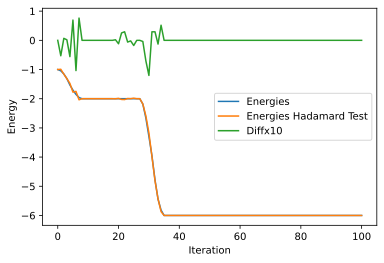

In [46]:
print('Energies: ')
Iterations = list(range(0, len(Energies)))
plt.plot(Iterations, Energies,  label='Energies')
plt.plot(Iterations, EnergiesHadTest, label='Energies Hadamard Test')
plt.plot(Iterations, np.multiply(Diff,10), label='Diffx10')
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()